In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import scipy.signal
import pandas

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [4]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.current = []
    
    def push(self, state, action, reward, done):
        state      = np.expand_dims(state, 0)
        #next_state = np.expand_dims(next_state, 0)
            
        action_idx = len(self.current)
            
        memory = [state, action, reward, action_idx, done]
            
        self.current.append(memory)
        
        for prevMemory in self.current:
            prevMemory[2] += reward * math.pow(gamma, action_idx - prevMemory[3])
    
    
    def startNewSequence(self):
        random.shuffle(self.buffer)
        
        for memoryIndex, memory in enumerate(self.current):
#             print(memoryIndex, memory[2])
            self.buffer.append(memory)
        
        self.current = []
    
    def sample(self, batch_size):
        state, action, reward, action_idx, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, action_idx, done
    
    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

<h2>Epsilon greedy exploration</h2>

In [5]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

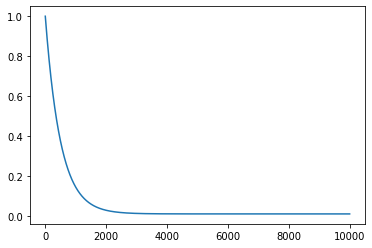

In [6]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Deep Q Network</h2>

In [7]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].item()
        else:
            action = random.randrange(env.action_space.n)
        
        return action

In [8]:
# model = DQN(env.observation_space.shape[0], env.action_space.n)

# if USE_CUDA:
#     model = model.cuda()
    
# optimizer = optim.Adam(model.parameters())

# replay_buffer = ReplayBuffer(1000)

outWidth = 76
outHeight = 51

<h2>Computing Temporal Difference Loss</h2>

In [9]:
def compute_td_loss(batch_size):
    state, action, reward, action_idx, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    #next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    #next_q_values = model(next_state)

    q_values = q_values.reshape([-1, outWidth * outHeight])
    #next_q_values = next_q_values.reshape([-1, outWidth * outHeight])

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    #next_q_value     = next_q_values.max(1)[0]
    
    
    expected_q_value = reward
        
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [10]:
def smooth(values, window):
    new_vals = pandas.DataFrame(values).rolling(window=window).mean().to_numpy()
    new_vals = new_vals[~np.isnan(new_vals)]
    return new_vals
    
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    
    plt.plot(smooth(rewards, window=7))
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.plot(smooth(losses, window=30))
    plt.show()

<h2>Training</h2>

<p><hr></p>

<h1>Atari Environment</h1>

In [11]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time


def startDriver():
    global driver

    driver = webdriver.Firefox()
    driver.get("http://localhost:3000/")
    time.sleep(1)

    if "auth0.com" in driver.current_url:
        el=driver.find_element_by_css_selector(".input-container.email input")
        el.send_keys("demo1@swiftlyai.com")
        el=driver.find_element_by_css_selector(".input-container.password input")
        el.send_keys("demoaccount1$")
        el=driver.find_element_by_css_selector(".ulp-button.ulp-button-default")
        el.click()
        time.sleep(3)


def clickAtPos(x, y):
    global driver
    el=driver.find_element_by_css_selector("html")
    action = webdriver.common.action_chains.ActionChains(driver)
#     action.move_to_element_with_offset(el, x, y + 835)

#     action.move_to_element_with_offset(el, x, y + 835)
#     action.move_to_element_with_offset(el, x, y + 780)
    action.move_to_element_with_offset(el, x, y)
    action.click()
    action.perform()

#     time.sleep(0.5)

In [12]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [13]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1, stride=1)
        )
        
        self.rect = driver.get_window_rect()
        
        
        
#         self.fc = nn.Sequential(
#             nn.Linear(self.feature_size(), 512),
#             nn.ReLU(),
#             nn.Linear(512, self.num_actions)
#         )

            
        self.outWidth = 76
        self.outHeight = 51
        
    def forward(self, x):
        x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            
            action_index = q_value.reshape([-1, self.outWidth * self.outHeight]).argmax(1).data[0]
            
            action_x = int(action_index / self.outHeight) 
            action_y = int(action_index % self.outHeight)
            
            return action_index, [int(action_x / self.outWidth * self.rect['width']), int(action_y / self.outHeight * self.rect['height'])]
        else:
            action_x = random.randrange(self.outWidth) 
            action_y = random.randrange(self.outHeight) 
            
            action_index = action_x * self.outHeight + action_y
             
            return action_index, [int(action_x / self.outWidth * self.rect['width']), int(action_y / self.outHeight * self.rect['height'])]
        return action

In [14]:
import os.path

startDriver()

rect = driver.get_window_rect()

model = CnnDQN([3, rect['height'], rect['width']])

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)

replay_initial = 400
replay_buffer = ReplayBuffer(600)


if os.path.exists("/home/bradley/model_test"):
    model.load_state_dict(torch.load("/home/bradley/model_test"))


In [15]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

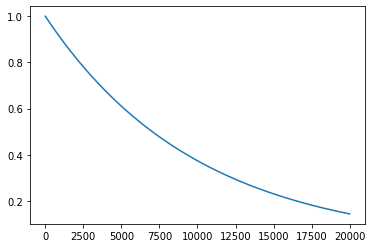

In [16]:
plt.plot([epsilon_by_frame(i) for i in range(20000)])

In [17]:
import skimage.io
import skimage.transform
import cv2
import numpy
import traceback
import selenium

num_frames = 1400000
batch_size = 32
gamma      = 0.50
frameStart = 7200


losses = []
all_rewards = []

def getState():
    global driver
    
    image = cv2.imdecode(np.frombuffer(driver.get_screenshot_as_png(), np.uint8), -1)
    
    width = image.shape[0]
    height = image.shape[1]
    
    shrunk = skimage.transform.resize(image, [int(width/2), int(height/2)])
    
    return numpy.swapaxes(shrunk, 0, 2)[:3,:,:]
    


def runLoop():
    global driver
    global frameStart
    
    state = getState()
    lastUrl = None
    episode_reward = 0
    
    
    try:
        for frame_idx in range(frameStart, num_frames + 1):
            epsilon = epsilon_by_frame(frame_idx)
            action_index, action_coords = model.act(state, epsilon)

            reward = 0

            try:
                url = driver.current_url

                if url != lastUrl:
                    lastUrl = url
                    reward = 10
                else:
                    reward = 0

                clickAtPos(action_coords[0], action_coords[1])
            except selenium.common.exceptions.MoveTargetOutOfBoundsException:
                reward = -10
                print(frame_idx, "failed step - bad click.")
            except Exception:
                reward = -10
                print(frame_idx, "failed step - other")
                traceback.print_exc()

            done = False
            if frame_idx % 50 == 0:
                done = True
                
            if frame_idx % 100 == 0:
                torch.save(model.state_dict(), "/home/bradley/model_test")
                torch.save(model.state_dict(), "/home/bradley/model_test_2")

            replay_buffer.push(state, action_index, reward, done)

            state = getState()
            episode_reward += reward

            if reward > 0:
                print(frame_idx, reward)

            if done:
                print(frame_idx, "reset")
                driver.get("http://localhost:3000/")
                time.sleep(1.5)
                state = getState()
                replay_buffer.startNewSequence()
                all_rewards.append(episode_reward)
                episode_reward = 0

            if len(replay_buffer) > replay_initial:
                loss = compute_td_loss(batch_size)
                losses.append(loss.data.item())

            if frame_idx % 100 == 0:
                plot(frame_idx, all_rewards, losses)
    except Exception:    
        traceback.print_exc()
        startDriver()
    frameStart = frame_idx

    
    

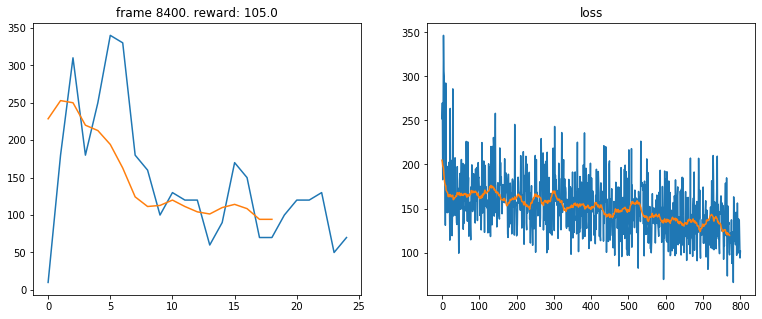

8402 10
8405 10
8421 10
8423 10
8424 10
8425 10
8426 10
8427 10


In [ ]:
while True:
    runLoop()